### AUTOENCODERS + ATTENTION MECHANISM

En este cuaderno se explora una modificación en autoencoders, basándonos en el autoencoder del modelo SDCA, el uso de autoencoders con mecanismos de atención para la imputación de valores faltantes. Los autoencoders son redes neuronales diseñadas para aprender una representación comprimida de los datos y luego reconstruir la información original. Incorporar un mecanismo de atención permite al modelo enfocarse en las características más importantes, mejorando su capacidad para imputar datos de manera precisa.

En este caso se usa el conjunto de datos reducido para ver que resultados se obtienen con menos datos.

Los objetivos principales de este cuaderno son:

- Utilizar autoencoders con atención para reconstruir datos faltantes y aprender representaciones robustas de los datos incompletos.
- valuar el rendimiento del autoencoder en la imputación bajo diferentes niveles de valores faltantes.
- Comparar este enfoque con métodos alternativos: XGBoost, KNN , RF, SDCA

Descripción del enfoque:
- Codificación y decodificación: El autoencoder aprende una representación comprimida de los datos y luego reconstruye los valores faltantes en las características.
- Atención: El mecanismo de atención ajusta la importancia de las características en el proceso de imputación, mejorando la precisión de la reconstrucción.
- Evaluación: Se mide la capacidad del autoencoder para imputar correctamente los valores faltantes CON DISTINTPOS PORCENTAJES DE PÉRDIDA.


#### Importaciones de librerías

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Multiply, Dropout
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical



In [20]:
# Hiperparámetros
batch_size = 32  # Tamaño del batch, cuántas muestras se procesan antes de actualizar los pesos
lr = 1e-3  # Learning rate o tasa de aprendizaje. Controla la magnitud de los cambios en los pesos durante el entrenamiento
epochs = 10  # Número de épocas, cuántas veces el modelo verá el conjunto de datos completo
kr = 1e-4  # Regularización L1 para evitar el sobreajuste penalizando los pesos grandes
drop_prec = 0.25  # Dropout, fracción de neuronas que se apagan aleatoriamente durante el entrenamiento para evitar el sobreajuste

In [21]:
# Cargar y procesar los datos
df_train = pd.read_parquet('../data/processed/df_train_reduced.parquet')
df_onehot = tf.keras.utils.to_categorical(df_train) #categorizar para representacion binaria
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)


In [22]:

# Dimensiones de entrada
feature_size = train_X.shape[1] #columnas
inChannel = train_X.shape[2] #canales, categorías únicas
input_shape = (feature_size, inChannel)

# Codificador con atención
inputs = Input(shape=input_shape) #capa de entrada

In [23]:
# Capas convolucionales del encoder
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(inputs)
x = MaxPooling1D(pool_size=2)(x) #reducir dimensionalidad
x = Dropout(drop_prec)(x) #apagamos neuronas
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)#aumentamos filtros
x = MaxPooling1D(pool_size=2)(x)#reducir dimensionalidad
x = Dropout(drop_prec)(x) #apagamos neuronas
x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x) #aumentamos filtros

# Mecanismo de atención
def attention_1d(inputs):
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)  # Capa densa para generar los pesos de atención
    attention = Multiply()([inputs, attention])  # Se aplica el mecanismo de atención multiplicando las activaciones de entrada 
    #por los pesos de atención, lo que permite que el modelo se centre en características relevantes. 
    return attention 

# Aplicar la atención después del codificador
x = attention_1d(x)

In [24]:
# Decodificador convolucional
x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x) #restaurar dimensiones perdidas en pooling de codificador
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x) #restaurar dimensiones perdidas en pooling de codificador
outputs = Conv1D(inChannel, 5, activation='softmax', padding='same')(x)


In [25]:
# Definir el modelo
attention_model = Model(inputs, outputs) # El modelo completo => codificador => mecanismo de atención => capas del decodificador.


In [26]:
# Compilar el modelo
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
attention_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1000, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1000, 32)  │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 500, 32)   │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 500, 32)   │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 500, 64)   │     10,304 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 250, 64)   │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 250, 64)   │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 250, 128)  │     41,088 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 250, 128)  │     16,512 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 250, 128)  │          0 │ conv1d_8[0][0],   │
│ (Multiply)          │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 250, 64)   │     41,024 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_2     │ (None, 500, 64)   │          0 │ conv1d_9[0][0]    │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 500, 32)   │     10,272 │ up_sampling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_3     │ (None, 1000, 32)  │          0 │ conv1d_10[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 3)   │        483 │ up_sampling1d_3[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,195 (469.51 KB)

 Trainable params: 120,195 (469.51 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:

# Definir DataGenerator, IGUAL QUE EN SDCA
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            self.x_missing[i, missing_index, :] = [1, 0, 0]

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [28]:

# Generar datos con el DataGenerator
train_generator = DataGenerator(batch_size=batch_size, x_dataset=train_X, missing_perc=0.1)
valid_generator = DataGenerator(batch_size=batch_size, x_dataset=valid_X, missing_perc=0.1)


In [29]:
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [30]:
attention_model_train = attention_model.fit(
    x=train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator,
    callbacks= [EarlyStopping]
    
)

Epoch 1/10
 3/87 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4882 - loss: 1.5350

/Users/celiacabello/miniconda3/envs/TFM/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5483 - loss: 1.1653 - val_accuracy: 0.8591 - val_loss: 0.4274
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8677 - loss: 0.4012 - val_accuracy: 0.8959 - val_loss: 0.3234
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8944 - loss: 0.3248 - val_accuracy: 0.9051 - val_loss: 0.2894
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8989 - loss: 0.2983 - val_accuracy: 0.9076 - val_loss: 0.2731
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9007 - loss: 0.2829 - val_accuracy: 0.9108 - val_loss: 0.2578
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9025 - loss: 0.2707 - val_accuracy: 0.9119 - val_loss: 0.2507
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9054 - loss: 0.2591 - val_accuracy: 0.9137 - val_loss: 0.2406
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9063 - loss: 0.2525 - val_accuracy: 0.9139 - val_loss: 0.

### plotting

/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_6353/946203232.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")


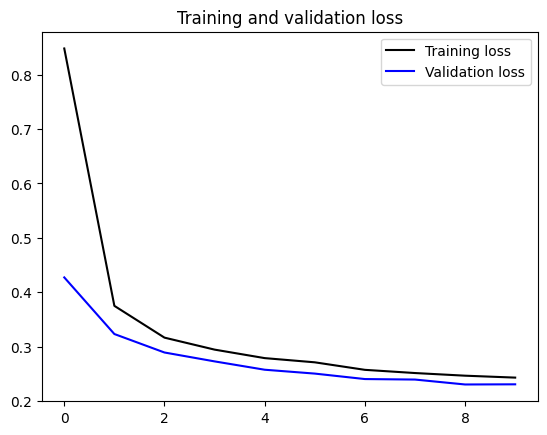

In [31]:
# plorring de la perdida 
loss = attention_model_train.history['loss']
val_loss = attention_model_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_6353/1770011942.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_6353/1770011942.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")


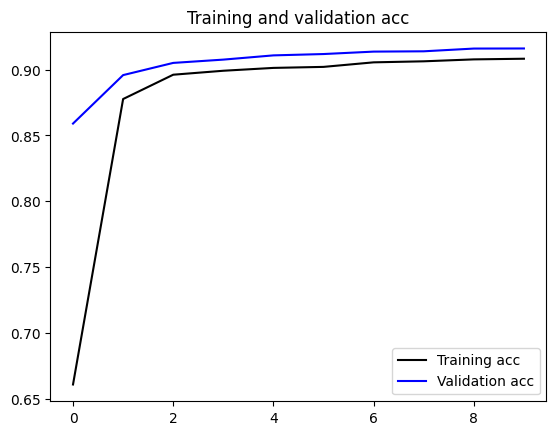

In [32]:
#plotting del accuracy
print(attention_model_train.history.keys())
acc = attention_model_train.history['accuracy'] 
val_acc = attention_model_train.history['val_accuracy']
plt.figure()
plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")
plt.title('Training and validation acc')
plt.legend()
plt.show()

In [33]:
print("Final Training Loss:", loss[-1])
print("Final Validation Loss:", val_loss[-1])
print("Final Training Accuracy:", acc[-1])
print("Final Validation Accuracy:", val_acc[-1])

Final Training Loss: 0.24328920245170593
Final Validation Loss: 0.23095755279064178
Final Training Accuracy: 0.908295214176178
Final Validation Accuracy: 0.9160802960395813


### TESTING

In [34]:
df_test = pd.read_parquet('../data/processed/df_test_reduced.parquet')
test_X = to_categorical(df_test)
test_X.shape

(877, 1000, 3)

#### Prediction on test data

In [35]:
import numpy as np

# Porcentajes de pérdida
missing_perc_list = [0.1, 0.2, 0.3, 0.4]

# Función para calcular la probabilidad de los genotipos 0, 1, 2
def cal_prob(predict_missing_onehot):
    predict_prob = predict_missing_onehot[:,:,1:3] / predict_missing_onehot[:,:,1:3].sum(axis=2, keepdims=True)
    return predict_prob

# Diccionario para almacenar los resultados de precisión por cada porcentaje
accuracy_summary = {}

# Iterar sobre los porcentajes de datos faltantes
for missing_perc in missing_perc_list:
    avg_accuracy = []
    
    # Generar índices faltantes de una vez para todas las muestras
    num_samples = test_X.shape[0]
    missing_indices = [np.random.randint(test_X.shape[1], size=int(missing_perc * test_X.shape[1])) for _ in range(num_samples)]
    
    # Generar la matriz con datos faltantes en un solo paso
    test_X_missing = test_X.copy()
    for i in range(num_samples):
        test_X_missing[i, missing_indices[i], :] = [1, 0, 0]  # Generar genotipos faltantes
    
    # Predecir utilizando el modelo entrenado en lotes en lugar de predicciones individuales
    predict_onehot = attention_model.predict(test_X_missing, batch_size=32)  # Ajustar el tamaño del batch si es necesario
    
    # Iterar sobre cada muestra para calcular las precisiones
    for i in range(num_samples):
        # Solo se consideran las posiciones faltantes
        predict_missing_onehot = predict_onehot[i:i + 1, missing_indices[i], :]
        
        # Predicción de la etiqueta
        predict_missing = np.argmax(predict_missing_onehot, axis=2)

        # Etiqueta real
        label_missing_onehot = test_X[i:i + 1, missing_indices[i], :]
        label_missing = np.argmax(label_missing_onehot, axis=2)

        # Calcular la precisión
        correct_prediction = np.equal(predict_missing, label_missing)
        accuracy = np.mean(correct_prediction)
        avg_accuracy.append(accuracy)

    # Guardar la precisión promedio para el porcentaje actual
    accuracy_summary[missing_perc] = np.mean(avg_accuracy)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [36]:
# Mostrar el resumen de las precisiones promedio
print("\n=== Resumen de precisión promedio por porcentaje de pérdida ===")
for perc, acc in accuracy_summary.items():
    print(f'Porcentaje de pérdida: {perc * 100}%, Precisión promedio: {acc:.4f}')


=== Resumen de precisión promedio por porcentaje de pérdida ===
Porcentaje de pérdida: 10.0%, Precisión promedio: 0.8369
Porcentaje de pérdida: 20.0%, Precisión promedio: 0.8358
Porcentaje de pérdida: 30.0%, Precisión promedio: 0.8329
Porcentaje de pérdida: 40.0%, Precisión promedio: 0.8289
